**Purpose:**  
This notebook merges and cleans the raw CSV files of the CIC-IIoT dataset.

- Load all CSVs in `data/attack/` and `data/benign/`
- Combine each group into a single DataFrame
- Apply the same cleaning function (drop duplicates, handle missing values)
- Save two cleaned outputs:
  - `data/merged/attack_merged_cleaned.csv`
  - `data/merged/benign_merged_cleaned.csv`

**Notes:**  
- No class labels (`Attack` / `Benign`) are written to disk.  
- Labeling logic will be applied dynamically in the modeling phase.

### Import Libraries

In [27]:
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 140)


### Defining Paths


In [28]:
ROOT = os.getcwd()
DATA_DIR = os.path.join(ROOT, "data")
ATTACK_DIR = os.path.join(DATA_DIR, "attack")
BENIGN_DIR = os.path.join(DATA_DIR, "benign")
MERGED_DIR = os.path.join(DATA_DIR, "merged")
os.makedirs(MERGED_DIR, exist_ok=True)

print("DATA_DIR :", DATA_DIR)
print("ATTACK_DIR:", ATTACK_DIR)
print("BENIGN_DIR:", BENIGN_DIR)
print("MERGED_DIR:", MERGED_DIR)


DATA_DIR : c:\Users\burakdogan\Desktop\ödev\data
ATTACK_DIR: c:\Users\burakdogan\Desktop\ödev\data\attack
BENIGN_DIR: c:\Users\burakdogan\Desktop\ödev\data\benign
MERGED_DIR: c:\Users\burakdogan\Desktop\ödev\data\merged


### Define merge function
This function:
- Lists all `.csv` files in a folder
- Reads and concatenates them
- Adds `source_file` column to preserve file origin
- Returns the merged DataFrame


In [29]:
def merge_csv_files(folder_path):
    """
    Merge all CSV files in a folder into a single DataFrame.
    Adds 'source_file' column to track origin.
    Prints which files are merged and how many rows were read from each.
    """
    csv_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".csv")])
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {folder_path}")

    print(f"\n Found {len(csv_files)} CSV files in: {folder_path}")
    print("Merging the following files:\n")

    merged_list = []
    total_rows = 0

    for i, file_name in enumerate(csv_files, start=1):
        file_path = os.path.join(folder_path, file_name)
        try:
            df = pd.read_csv(file_path)
            df["source_file"] = file_name
            merged_list.append(df)
            n_rows = len(df)
            total_rows += n_rows
            print(f"  {i:02d}. {file_name:<40} → {n_rows:>10,} rows loaded")
        except Exception as e:
            print(f"  {i:02d}. {file_name:<40}  Failed to load ({e})")

    merged_df = pd.concat(merged_list, ignore_index=True)

    print("\n Merge completed successfully")
    print(f" Total files merged : {len(merged_list)} / {len(csv_files)}")
    print(f" Total rows combined: {total_rows:,}")
    print(f" Final merged shape : {merged_df.shape[0]:,} rows × {merged_df.shape[1]} columns\n")

    return merged_df


In [30]:
attack_df = merge_csv_files(ATTACK_DIR)
benign_df = merge_csv_files(BENIGN_DIR)


 Found 10 CSV files in: c:\Users\burakdogan\Desktop\ödev\data\attack
Merging the following files:

  01. attack_samples_10sec.csv                 →     16,350 rows loaded
  02. attack_samples_1sec.csv                  →     90,391 rows loaded
  03. attack_samples_2sec.csv                  →     44,744 rows loaded
  04. attack_samples_3sec.csv                  →     29,627 rows loaded
  05. attack_samples_4sec.csv                  →     22,165 rows loaded
  06. attack_samples_5sec.csv                  →     17,695 rows loaded
  07. attack_samples_6sec.csv                  →     14,723 rows loaded
  08. attack_samples_7sec.csv                  →     12,050 rows loaded
  09. attack_samples_8sec.csv                  →     20,820 rows loaded
  10. attack_samples_9sec.csv                  →     16,434 rows loaded

 Merge completed successfully
 Total files merged : 10 / 10
 Total rows combined: 284,999
 Final merged shape : 284,999 rows × 95 columns


 Found 10 CSV files in: c:\Users\burakd

### Exploratory Data Analysis (EDA)
In this section we explore the merged Attack and Benign datasets **before any cleaning**.

Goals:
1. Understand data scale, structure, and completeness.
2. Identify duplicate and missing patterns.
3. Examine numeric and categorical feature distributions.
4. Provide visual summaries for the paper’s *Data Preparation* section.

#### Dataset Composition — Sample Distribution
We analyze the number of rows for Attack and Benign datasets,
and visualize the overall balance between them.

=== DATASET SIZE SUMMARY ===
Total samples  : 685,671
Attack samples : 284,999  (41.56%)
Benign samples : 400,672  (58.44%)



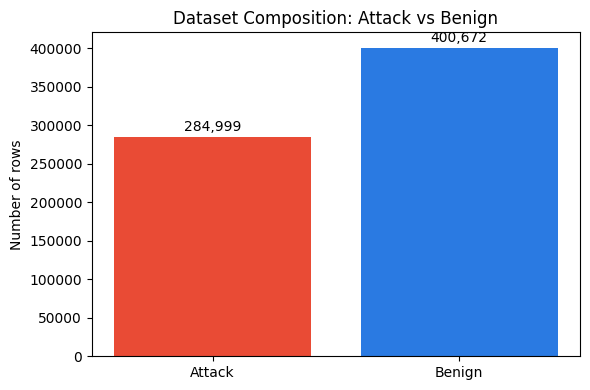

In [31]:
attack_rows = len(attack_df)
benign_rows = len(benign_df)
total_rows = attack_rows + benign_rows

# textual summary
print("=== DATASET SIZE SUMMARY ===")
print(f"Total samples  : {total_rows:,}")
print(f"Attack samples : {attack_rows:,}  ({attack_rows/total_rows*100:.2f}%)")
print(f"Benign samples : {benign_rows:,}  ({benign_rows/total_rows*100:.2f}%)\n")

# bar chart
plt.figure(figsize=(6,4))
bars = plt.bar(["Attack", "Benign"], [attack_rows, benign_rows], color=["#E94B35","#2A7AE2"])
plt.title("Dataset Composition: Attack vs Benign", fontsize=12)
plt.ylabel("Number of rows")
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + total_rows*0.005, f"{h:,}", ha="center", va="bottom", fontsize=10)
plt.tight_layout()
plt.show()

=== LABEL2 (Main Category) SUMMARY ===
recon: 105,848 rows (37.14%)
dos: 57,736 rows (20.26%)
ddos: 56,692 rows (19.89%)
mitm: 25,490 rows (8.94%)
malware: 24,177 rows (8.48%)
web: 9,040 rows (3.17%)
bruteforce: 6,016 rows (2.11%)



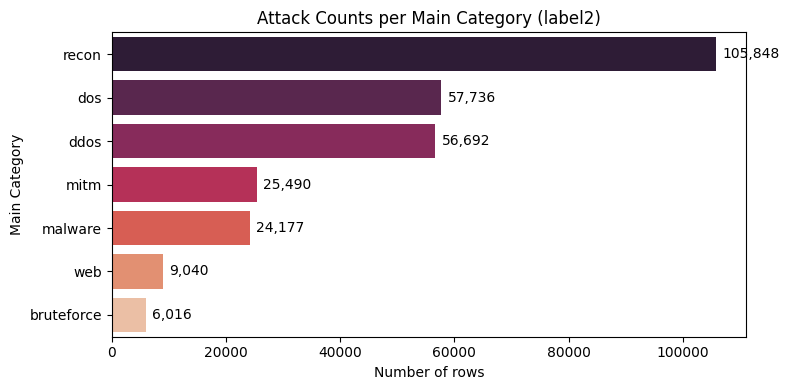

In [32]:
# 2) label2 = main attack category (e.g., ddos, recon, web, bruteforce, mitm, ...)
label_col = "label2"
if label_col not in attack_df.columns:
    raise KeyError(f"{label_col} not found in attack_df columns")

label2_counts = attack_df[label_col].value_counts().sort_values(ascending=False)
label2_df = label2_counts.reset_index()
label2_df.columns = ["Attack Category", "Count"]
label2_df["Percent"] = (label2_df["Count"] / len(attack_df) * 100).round(2)

# textual summary
print("=== LABEL2 (Main Category) SUMMARY ===")
for i, row in label2_df.iterrows():
    print(f"{row['Attack Category']}: {row['Count']:,} rows ({row['Percent']}%)")
print("")

# barplot
plt.figure(figsize=(8, max(4, 0.4*len(label2_df))))
sns.barplot(x="Count", y="Attack Category", data=label2_df, palette="rocket")
plt.title("Attack Counts per Main Category (label2)")
plt.xlabel("Number of rows")
plt.ylabel("Main Category")
for i, v in enumerate(label2_df["Count"]):
    plt.text(v + max(label2_df["Count"])*0.01, i, f"{v:,}", va='center')
plt.tight_layout()
plt.show()

#### Attack breakdown by type
Attack CSV filenames (e.g., `attack_samples_1sec_3.csv`) can be used
to infer which attack type each row belongs to.
We will extract attack types from the `source_file` column.


=== TOTAL DATA SUMMARY ===
Total rows   : 685,671
Attack rows  : 284,999 (41.56%)
Benign rows  : 400,672 (58.44%)


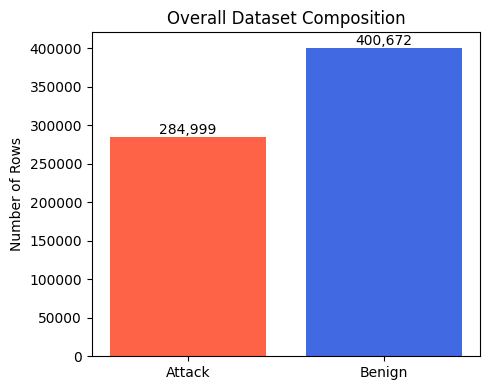

In [33]:
attack_rows = len(attack_df)
benign_rows = len(benign_df)
total_rows = attack_rows + benign_rows

print("=== TOTAL DATA SUMMARY ===")
print(f"Total rows   : {total_rows:,}")
print(f"Attack rows  : {attack_rows:,} ({attack_rows/total_rows*100:.2f}%)")
print(f"Benign rows  : {benign_rows:,} ({benign_rows/total_rows*100:.2f}%)")

plt.figure(figsize=(5,4))
plt.bar(["Attack", "Benign"], [attack_rows, benign_rows], color=["tomato","royalblue"])
plt.title("Overall Dataset Composition")
plt.ylabel("Number of Rows")
for i, v in enumerate([attack_rows, benign_rows]):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [34]:
print(f"Attack dataset: {attack_df.shape[0]:,} rows × {attack_df.shape[1]:,} columns")
print(f"Benign dataset: {benign_df.shape[0]:,} rows × {benign_df.shape[1]:,} columns")

print("\nData type summary (top 10 dtypes):")
attack_types = attack_df.dtypes.value_counts().to_dict()
benign_types = benign_df.dtypes.value_counts().to_dict()
print(f"Attack types: {attack_types}")
print(f"Benign types: {benign_types}")


Attack dataset: 284,999 rows × 95 columns
Benign dataset: 400,672 rows × 95 columns

Data type summary (top 10 dtypes):
Attack types: {dtype('float64'): 47, dtype('O'): 24, dtype('int64'): 24}
Benign types: {dtype('float64'): 47, dtype('O'): 24, dtype('int64'): 24}


#### Column Structure Analysis — Attack vs Benign

In [35]:
# Column sets
attack_cols = set(attack_df.columns)
benign_cols = set(benign_df.columns)

# Overlap and unique sets
common_cols = sorted(list(attack_cols.intersection(benign_cols)))
unique_attack_cols = sorted(list(attack_cols - benign_cols))
unique_benign_cols = sorted(list(benign_cols - attack_cols))

# Summary statistics
attack_col_count = len(attack_cols)
benign_col_count = len(benign_cols)
common_count = len(common_cols)
unique_attack_count = len(unique_attack_cols)
unique_benign_count = len(unique_benign_cols)

print("=== COLUMN STRUCTURE SUMMARY ===")
print(f"Attack columns : {attack_col_count}")
print(f"Benign columns : {benign_col_count}")
print(f"Common columns : {common_count} ({common_count/max(attack_col_count, benign_col_count)*100:.2f}% overlap)")
print(f"Attack-only columns : {unique_attack_count}")
print(f"Benign-only columns : {unique_benign_count}")

if unique_attack_cols:
    print("\n Columns present only in Attack:")
    for c in unique_attack_cols:
        print("  -", c)

if unique_benign_cols:
    print("\n Columns present only in Benign:")
    for c in unique_benign_cols:
        print("  -", c)

=== COLUMN STRUCTURE SUMMARY ===
Attack columns : 95
Benign columns : 95
Common columns : 95 (100.00% overlap)
Attack-only columns : 0
Benign-only columns : 0


#### Missing values overview
Visualize missing value ratios per column for both datasets.


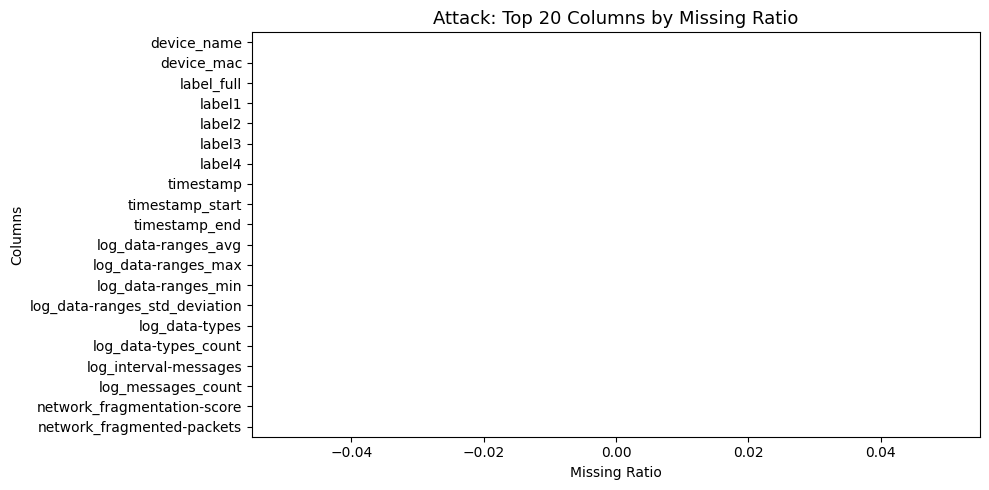

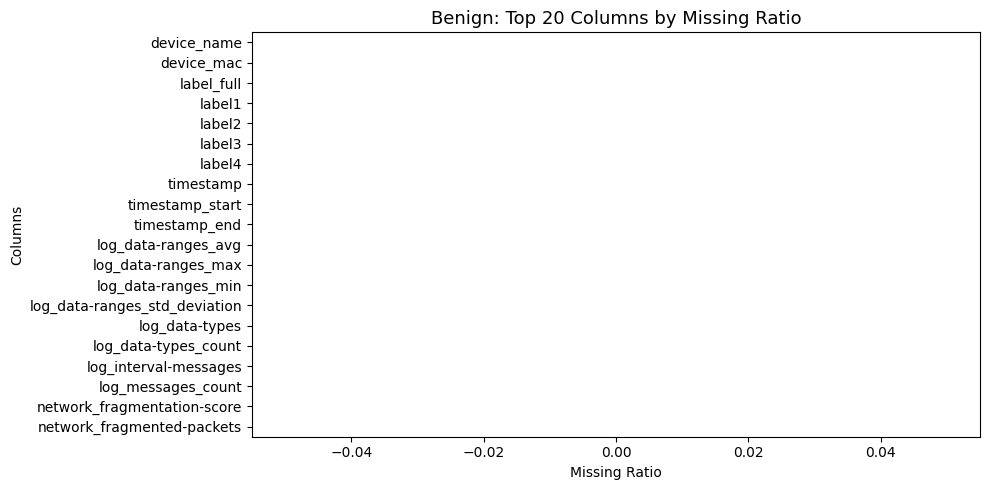

Attack columns with >30% missing: 0
Benign columns with >30% missing: 0


In [36]:
def plot_missing_ratio(df, name):
    missing_ratio = df.isnull().mean().sort_values(ascending=False)
    plt.figure(figsize=(10,5))
    sns.barplot(x=missing_ratio.values[:20], y=missing_ratio.index[:20], palette="magma")
    plt.title(f"{name}: Top 20 Columns by Missing Ratio", fontsize=13)
    plt.xlabel("Missing Ratio")
    plt.ylabel("Columns")
    plt.tight_layout()
    plt.show()
    return missing_ratio

missing_attack = plot_missing_ratio(attack_df, "Attack")
missing_benign = plot_missing_ratio(benign_df, "Benign")

print(f"Attack columns with >30% missing: {(missing_attack>0.3).sum()}")
print(f"Benign columns with >30% missing: {(missing_benign>0.3).sum()}")

#### Duplicate and unique values analysis
Check how many duplicate rows exist and examine potential redundancy.


Attack duplicate rows: 0 (0.00%)
Benign duplicate rows: 0 (0.00%)


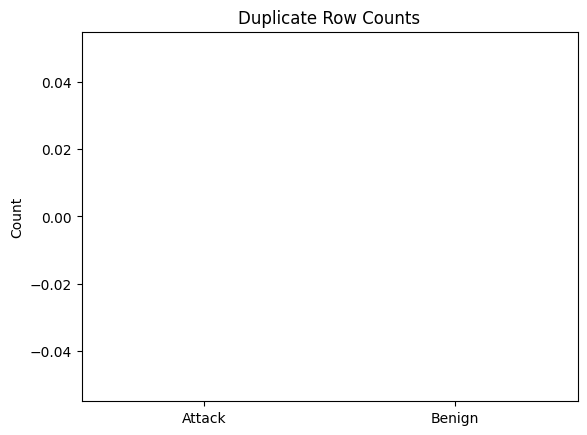

In [37]:
attack_dups = attack_df.duplicated().sum()
benign_dups = benign_df.duplicated().sum()

print(f"Attack duplicate rows: {attack_dups:,} ({attack_dups/len(attack_df)*100:.2f}%)")
print(f"Benign duplicate rows: {benign_dups:,} ({benign_dups/len(benign_df)*100:.2f}%)")

# Visual compare row count vs duplicates
plt.bar(["Attack", "Benign"], [attack_dups, benign_dups], color=["tomato","skyblue"])
plt.title("Duplicate Row Counts")
plt.ylabel("Count")
plt.show()


#### Numeric feature distributions
Inspect the most common numeric columns and plot their distributions to detect outliers or scaling issues.

Common numeric columns to visualize: ['log_data-ranges_avg', 'log_data-ranges_max', 'log_data-ranges_min', 'log_data-ranges_std_deviation', 'log_data-types_count']


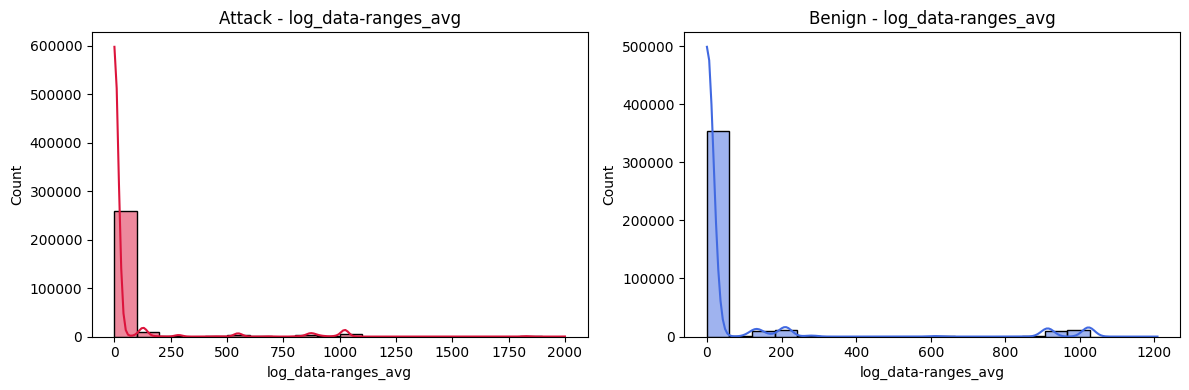

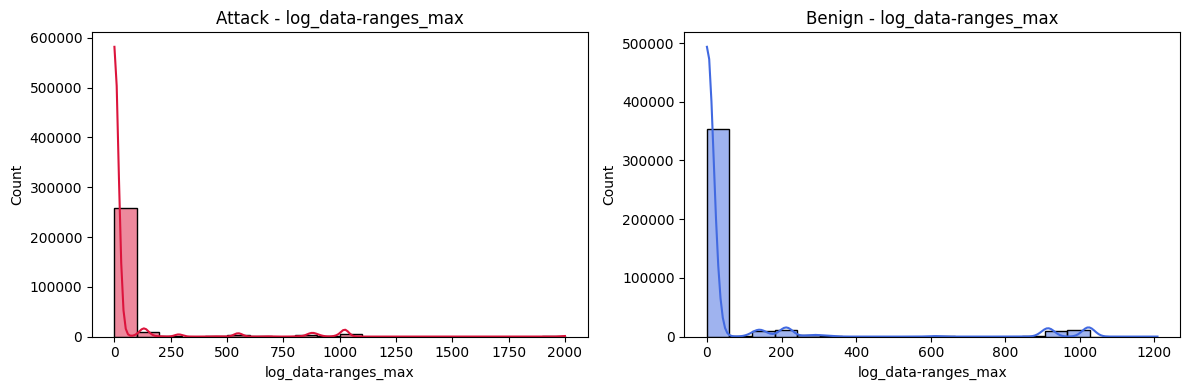

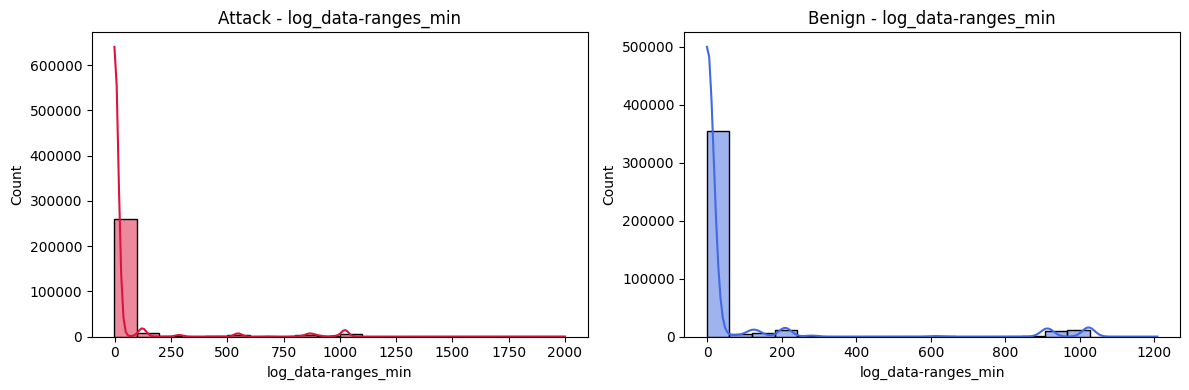

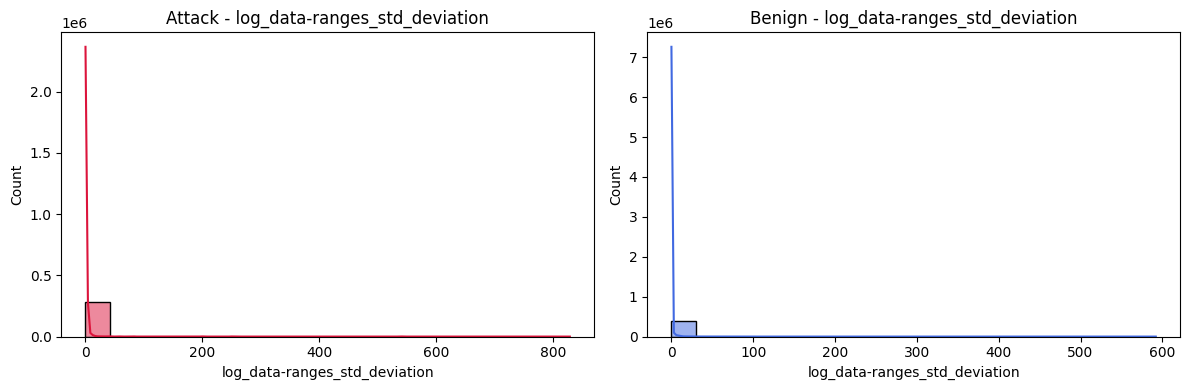

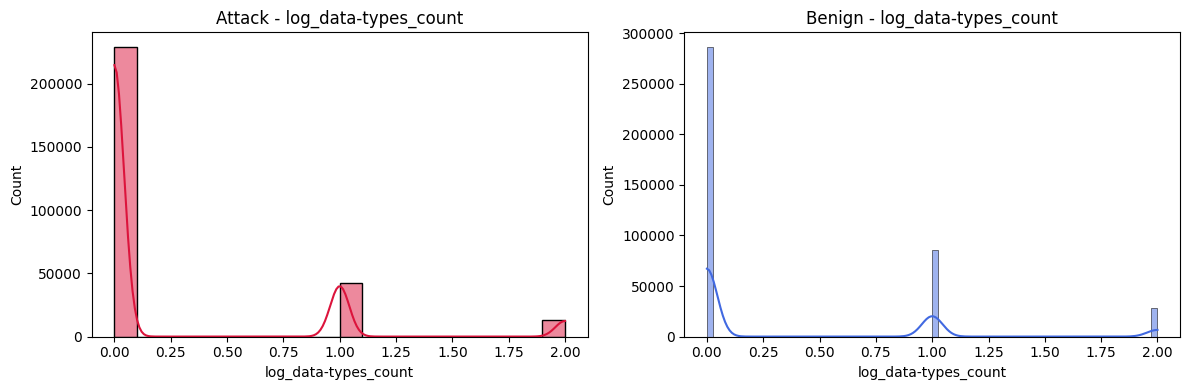

In [38]:
numeric_cols_attack = attack_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_benign = benign_df.select_dtypes(include=[np.number]).columns.tolist()

common_numeric = [c for c in numeric_cols_attack if c in numeric_cols_benign][:5]
print("Common numeric columns to visualize:", common_numeric)

for col in common_numeric:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    sns.histplot(attack_df[col], kde=True, ax=axes[0], color="crimson")
    axes[0].set_title(f"Attack - {col}")
    sns.histplot(benign_df[col], kde=True, ax=axes[1], color="royalblue")
    axes[1].set_title(f"Benign - {col}")
    plt.tight_layout()
    plt.show()


#### Correlation matrix (numeric subset)
To see relationships between numeric features and detect collinearity.

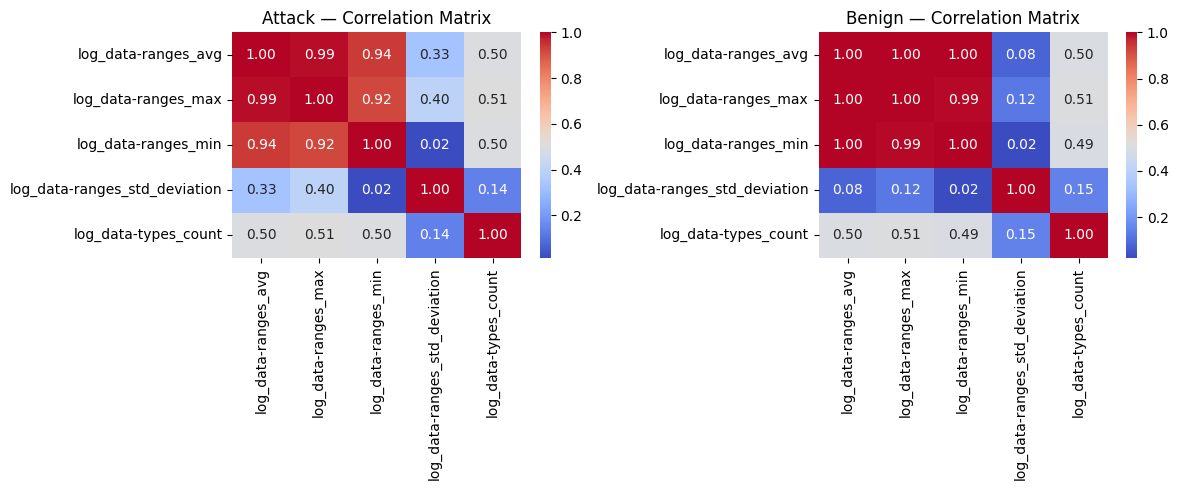

In [39]:
if common_numeric:
    corr_attack = attack_df[common_numeric].corr()
    corr_benign = benign_df[common_numeric].corr()

    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    sns.heatmap(corr_attack, cmap="coolwarm", ax=axes[0], annot=True, fmt=".2f")
    axes[0].set_title("Attack — Correlation Matrix")
    sns.heatmap(corr_benign, cmap="coolwarm", ax=axes[1], annot=True, fmt=".2f")
    axes[1].set_title("Benign — Correlation Matrix")
    plt.tight_layout()
    plt.show()


#### Categorical feature overview
Show top categories for non-numeric features (if present).

Common categorical columns to visualize: ['device_name', 'device_mac', 'label_full']


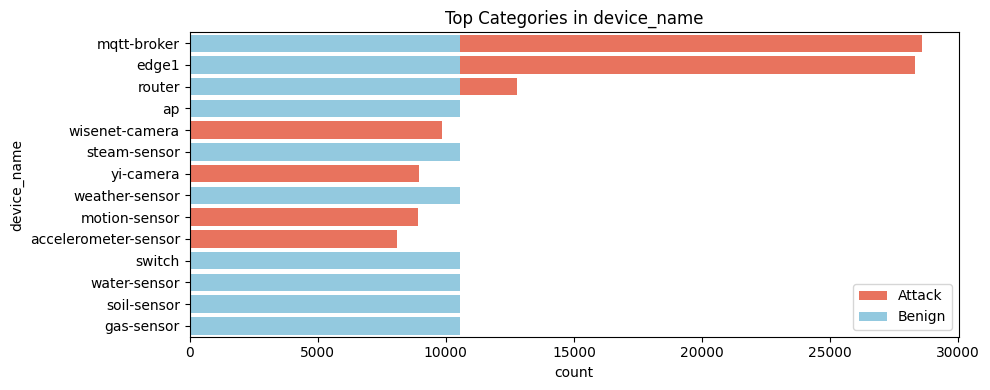

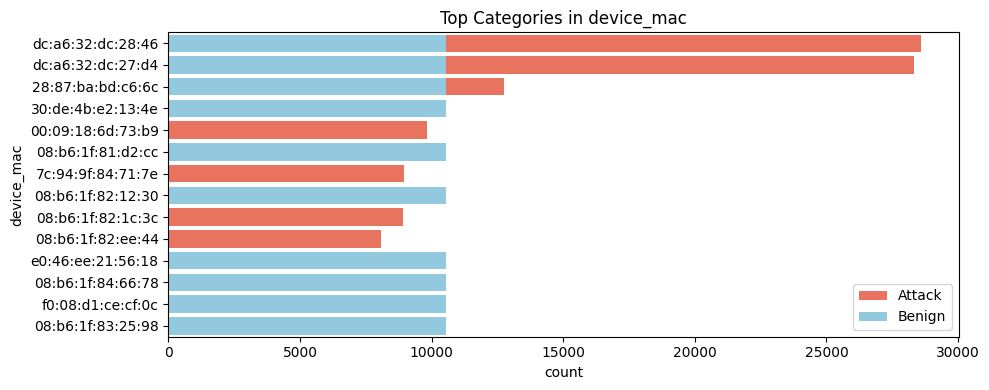

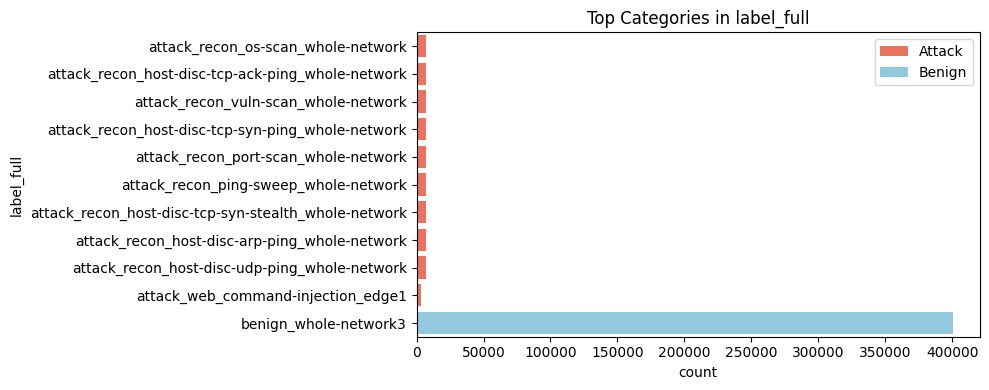

In [40]:
cat_cols_attack = attack_df.select_dtypes(exclude=[np.number]).columns.tolist()
cat_cols_benign = benign_df.select_dtypes(exclude=[np.number]).columns.tolist()

# Common categorical columns (for example, protocol, device, etc.)
common_cats = [c for c in cat_cols_attack if c in cat_cols_benign and c not in ['source_file']][:3]
print("Common categorical columns to visualize:", common_cats)

for col in common_cats:
    plt.figure(figsize=(10,4))
    sns.countplot(y=col, data=attack_df, order=attack_df[col].value_counts().index[:10], color="tomato", label="Attack")
    sns.countplot(y=col, data=benign_df, order=benign_df[col].value_counts().index[:10], color="skyblue", label="Benign")
    plt.title(f"Top Categories in {col}")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Clean merged DataFrames (feature reduction by data quality)
Steps:
1. Drop duplicate rows  
2. Drop columns with >30% missing values  
3. Fill remaining NaN values with 0  
4. Save cleaned results


In [ ]:
def clean_dataframe_inline(df_name, df):
    """
    Comprehensive cleaning function for CIC-IIoT raw data.
    Ensures label columns are preserved and only drops features
    with >51% missing values.
    """
    print(f"\n🧹 Cleaning {df_name} ...")
    initial_rows, initial_cols = df.shape

    # Duplicate removal
    before = len(df)
    df.drop_duplicates(inplace=True)
    print(f"→ Removed duplicates: {before - len(df)} ({(before - len(df)) / before * 100:.2f}%)")

    # Missing value analysis
    missing_ratio = df.isnull().mean().sort_values(ascending=False)
    
    # Protect key label columns from dropping
    protected_cols = ["label1", "label2", "label3", "label4", "label_full"]
    
    # High missing threshold updated to 51%
    high_missing = missing_ratio[
        (missing_ratio > 0.51) & (~missing_ratio.index.isin(protected_cols))
    ]
    med_missing = missing_ratio[
        (missing_ratio > 0.05) & (missing_ratio <= 0.51)
    ]

    print(f"→ Columns with >51% missing: {len(high_missing)}")
    print(f"→ Columns with 5–51% missing: {len(med_missing)}")

    # Drop features with too many NaNs (but never labels)
    if not high_missing.empty:
        df.drop(columns=high_missing.index.tolist(), inplace=True)
        print(f"   Dropped columns: {', '.join(high_missing.index[:5])}... (total {len(high_missing)})")

    # Numeric & categorical imputation
    num_cols = df.select_dtypes(include=["number"]).columns
    cat_cols = df.select_dtypes(exclude=["number"]).columns

    # Fill numeric with median (robust against outliers)
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    # Fill categorical with mode (most frequent)
    for col in cat_cols:
        if df[col].isnull().any():
            df[col].fillna(df[col].mode()[0], inplace=True)

    # Feature uniformity check (constant or near-constant)
    nunique_ratio = df.nunique() / len(df)
    low_var_cols = nunique_ratio[
        (nunique_ratio < 0.0001) & (~nunique_ratio.index.isin(protected_cols))
    ].index.tolist()
    if low_var_cols:
        df.drop(columns=low_var_cols, inplace=True)
        print(f"→ Dropped near-constant features: {len(low_var_cols)}")

    # Sanity check
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    final_rows, final_cols = df.shape
    print(f" Cleaned shape: {final_rows:,} rows × {final_cols} cols "
          f"({initial_rows - final_rows} rows dropped, {initial_cols - final_cols} cols removed)")

    # Final confirmation for label columns
    existing_labels = [c for c in protected_cols if c in df.columns]
    print(f" Labels retained: {', '.join(existing_labels)}")

    return df

In [49]:
combined_df = pd.concat([attack_df, benign_df], ignore_index=True)
print(f"\n Combined dataset shape before cleaning: {combined_df.shape}")

combined_df = clean_dataframe_inline("Combined (Attack+Benign)", combined_df)

merged_path = os.path.join(MERGED_DIR, "combined_cleaned.csv")
combined_df.to_csv(merged_path, index=False)


 Combined dataset shape before cleaning: (685671, 95)

🧹 Cleaning Combined (Attack+Benign) ...
→ Removed duplicates: 0 (0.00%)
→ Columns with >51% missing: 0
→ Columns with 5–51% missing: 0
→ Dropped near-constant features: 22
✅ Cleaned shape: 685,671 rows × 73 cols (0 rows dropped, 22 cols removed)
 Labels retained: label1, label2, label3, label4, label_full


In [50]:
print("Combined df shape:", combined_df.shape)
print(combined_df.columns.tolist())

Combined df shape: (685671, 73)
['label_full', 'label1', 'label2', 'label3', 'label4', 'timestamp', 'timestamp_start', 'timestamp_end', 'log_data-ranges_avg', 'log_data-ranges_max', 'log_data-ranges_min', 'log_data-ranges_std_deviation', 'log_interval-messages', 'log_messages_count', 'network_fragmentation-score', 'network_fragmented-packets', 'network_header-length_avg', 'network_header-length_std_deviation', 'network_interval-packets', 'network_ip-flags_avg', 'network_ip-flags_std_deviation', 'network_ip-length_avg', 'network_ip-length_max', 'network_ip-length_min', 'network_ip-length_std_deviation', 'network_ips_all', 'network_ips_all_count', 'network_ips_dst', 'network_ips_dst_count', 'network_ips_src', 'network_ips_src_count', 'network_macs_all', 'network_macs_dst', 'network_macs_src', 'network_mss_avg', 'network_mss_std_deviation', 'network_packet-size_avg', 'network_packet-size_max', 'network_packet-size_min', 'network_packet-size_std_deviation', 'network_packets_all_count', 'ne